In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import h5py

In [2]:
x = utils.get_data(directory= r'D:\runs\Run_33_66_72_1_2021-06-24')



TypeError: get_positions() takes from 1 to 2 positional arguments but 3 were given

In [3]:
x.positions

,Timestep,ID,type,radius,x,y,z,biomass,time
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002,87.112534,0.000000
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004,1371.210192,0.000000
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005,1349.896428,0.000000
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005,112.429934,0.000000
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005,108.984929,0.000000
...,...,...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010,73.292227,97.222222
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010,118.991185,97.222222
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010,91.107271,97.222222
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010,73.315084,97.222222


<Closed HDF5 file>

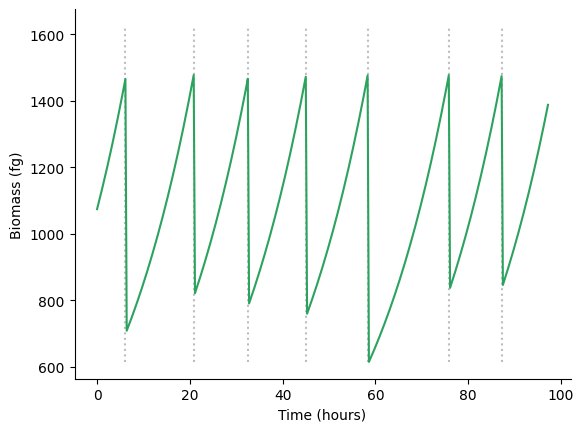

In [4]:
fig, ax = plt.subplots()
plot.biomass_time(x.positions,id=1,ax=ax)
plt.show()

In [3]:
def collect(time,df=x.positions):
    fitness = pd.DataFrame(columns=['ID','Fitness'])
    for cell in tqdm(df[(df.Timestep==time)].ID):
        fitness = fitness.append(pd.DataFrame([[cell,x.get_fitness2(time,cell)]],columns=['ID','Fitness']),ignore_index=True)
    return fitness
#fit = collect(x,30000)

In [57]:
def collect(x,time):
    temp = x.positions
    IDs = temp[(temp.Timestep==time)].ID
    fits = [x.get_fitness2(time,cell) for cell in tqdm(IDs)]

    return IDs,fits
#IDs,fits = collect(x,30000)
pd.DataFrame([IDs.values,fits]).T

 37%|███▋      | 1921/5234 [00:55<01:36, 34.51it/s]

KeyboardInterrupt: 

In [6]:
from dask import delayed
import dask.multiprocessing
dask.config.set(scheduler='processes',num_workers=8)

In [8]:
fits = delayed(x.collect_fitness)(30000)
fits.compute()

TypeError: h5py objects cannot be pickled

In [32]:
cells,times,fits = [[cell,time,[x.get_fitness2(time,cell) for cell in temp[temp.Timestep==time].ID]] for time in [0,100,1000]]

In [5]:
x.fitness

,Time,ID,Fitness


In [2]:
file = r'D:\runs\Run_33_66_72_1_2021-06-24\trajectory.h5'
f = h5py.File(file,'r')

In [21]:
for i in f.keys():
    print(i)

concentration
id
radius
type
x
y
z


In [46]:
def get_positions(h5,timepoint=0):
    """
    Extract the x, y, z position of each cell at a given timepoint

    Args:
        timepoint (int):
            The simulation timestep to get the position data from.
    
    Returns:
        pandas.DataFrame:
            Dataframe containing Timestep, ID, type,x, y, z columns
    """
    return pd.concat([pd.Series(np.ones(h5['x'][str(timepoint)].len())*int(timepoint),dtype=int,name='Timestep'),
    pd.Series(h5['id'][str(timepoint)],name='ID'),
    pd.Series(h5['type'][str(timepoint)],name='type'),
    pd.Series(h5['radius'][str(timepoint)],name='radius'),
    pd.Series(h5['x'][str(timepoint)],name='x'),
    pd.Series(h5['y'][str(timepoint)],name='y'),
    pd.Series(h5['z'][str(timepoint)],name='z')],axis=1)
def collect_positions(h5):
    """get cell locations for all timesteps and aggregate into a dataframe
    """
    dfs = list()
    timepoints = [key for key in h5['concentration']['co2'].keys()]
    timepoints.sort(key=int)
    for t in tqdm(timepoints):
        dfs.append(get_positions(h5,t))
    temp = pd.concat(dfs,ignore_index=True)
    idx = temp[temp.type==0].index
    return temp.drop(idx).reset_index(drop=True)


In [48]:
df = collect_positions(f)

100%|██████████| 351/351 [00:01<00:00, 261.16it/s]


In [49]:
df

,Timestep,ID,type,radius,x,y,z
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005
...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010


In [53]:
keys = f['concentration'].keys()
for key in keys:
    print(key)

co2
o2
sub
suc


In [100]:
nutes = list(keys)

In [69]:
x1 = f['concentration']['co2']['100'].__array__()
x2 = f['concentration']['co2']['200'].__array__()
np.stack([x1,x2]).shape

(2, 1, 50, 50)

In [94]:
def get_nutrient_grid(f):
    keys = list(f['concentration'].keys())
    timepoints = [k for k in f['concentration'][keys[0]].keys()]
    timepoints.sort(key=int)
    stacks = list()
    for key in keys:
        dfs = list()
        for time in timepoints:
            dfs.append(f['concentration'][key][time])
        stacks.append(np.stack(dfs))
    grid = np.stack(stacks,axis=1)
    return grid

In [97]:
nute_grid = get_nutrient_grid(f)
nute_grid.shape

(351, 4, 1, 50, 50)

In [98]:
def get_grid_idx(array,value):
    """
    Find the nutrient grid index value. Taken from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array.

    Args:
        array (numpy.array):
            1D Array containing the grid positions
        value (float):
            Cell location to map to the grid
    Returns:
        index (int):
            Grid index
    """
    n = len(array)

    jl = 0# Initialize lower
    ju = n-1# and upper limits.
    while (ju-jl > 1):# If we are not yet done,
        jm=(ju+jl) >> 1# compute a midpoint with a bitshift
        if (value >= array[jm]):
            jl=jm# and replace either the lower limit
        else:
            ju=jm# or the upper limit, as appropriate.
        # Repeat until the test condition is satisfied.
    if (value == array[0]):# edge cases at bottom
        return 0
    elif (value == array[n-1]):# and top
        return n-1
    else:
        return jl

In [118]:
def get_local_con(df,obj,timestep,cellID,nute_grid):
    """
    Get the local nutrient concentration of a cell

    Args:

        timestep (int):
            The timestep at which to check the concentration
        cellID (int):
            The cell identification number
    
    Returns:
        Nutrient Concentration (float):
            The concentration of the specified nutrient within the cell's grid
    """
    cell_locs = df
    grid = [np.linspace(0,obj.metadata['Dimensions'][x],obj.dims[x]) for x in range(3)]
    grid_loc = [get_grid_idx(grid[i],cell_locs[cell_locs.ID ==cellID][d].values[0]) for i,d in enumerate(['x','y','z'])]

    return nute_grid[timestep,:,grid_loc[2],grid_loc[0],grid_loc[1]]



In [155]:
def get_fitness(df,obj,timestep,cellID,nutes):
    """
    Get the fitness of an individual cell based on the relative Monod growth rate at a given timestep

    Args:
        timestep (int):
            The timestep at which to check the concentration
        cellID (int):
            The cell identification number
    Returns:
        float:
            The Monod growth rate (1/s)
    """
        # TODO Speed up or parallelize this computation
    cell_type = df[(df.Timestep ==timestep) & (df.ID ==cellID)].type.values[0]
    if df[(df.Timestep ==timestep) & (df.ID ==cellID)].empty:
        print('Timestep or cell ID not found')
        return
    concentrations = get_local_con(df,obj,list(df.Timestep.unique()).index(timestep),cellID,nute_grid)
    if cell_type == 1:
        metadata = obj.metadata['cyano']
        light = concentrations[nutes.index('sub')]
        co2 = concentrations[nutes.index('co2')]
        fitness = metadata['GrowthRate'] * (light / (metadata['K_s']['sub'] + light)) * (co2 / (metadata['K_s']['co2'] + co2))
        return fitness
    elif cell_type == 2:
        metadata = obj.metadata['ecw']
        suc = concentrations[nutes.index('suc')]
        o2 = concentrations[nutes.index('o2')]
        maintenance = metadata['GrowthParams']['Maintenance'] * (o2 / (metadata['K_s']['o2'] + o2))
        decay = metadata['GrowthParams']['Decay']
        fitness = metadata['GrowthRate'] * (suc / (metadata['K_s']['suc'] + suc)) * (o2 / (metadata['K_s']['o2'] + o2))
        return fitness - maintenance - decay

In [119]:
get_local_con(df,x,100,10,nute_grid)

array([43.69545467,  0.18139445,  0.1       ,  0.12226906])

In [162]:
get_fitness(df,x,20000,95,nutes)

2.3152493025670285e-05

In [158]:
df[(df.Timestep ==100)]


,Timestep,ID,type,radius,x,y,z
99,100,95,2,4.418830e-07,0.000025,0.000018,0.000002
100,100,11,1,9.645286e-07,0.000097,0.000027,0.000004
101,100,9,1,9.595050e-07,0.000193,0.000002,0.000005
102,100,85,2,4.811057e-07,0.000213,0.000014,0.000005
103,100,75,2,4.761421e-07,0.000125,0.000060,0.000005
...,...,...,...,...,...,...,...
196,100,52,2,4.423813e-07,0.000408,0.000463,0.000005
197,100,91,2,4.468499e-07,0.000369,0.000451,0.000005
198,100,18,1,7.686087e-07,0.000481,0.000494,0.000006
199,100,101,2,4.307591e-07,0.000301,0.000426,0.000002


In [153]:
def single_cell_growth(self=x,timepoint=0):
    """
    Extract single cell biomass over time from the HDF5 data. 

    Args:
        timepoint (int):
            The simulation timestep to calculate from. Default = 0.
    """
    self.hrs = [int(x)/360 for x in self.timepoints]
    df = pd.DataFrame(columns=['id','type','time','biomass'])
    # loop over all cell ids, c, from time = 0
    for c in self.h5['id'][str(timepoint)]:
        # loop over all timepoints t
        for t,h in zip(self.timepoints,self.hrs):
            # get list of ids from timepoint t
            ids = self.h5['id'][t]
            arr = ids.__array__(ids.dtype)
            # make sure cell id matches id of interest
            i = np.where(arr == c)[0][0]
            # get radius
            radius = self.h5['radius'][t][i]
            volume = 4/3*np.pi*radius**3 #volume in m^3
            # get celltype
            celltype=self.h5['type'][t][i]
            # color cells
            if celltype==1:
                color = '#2ca25f'
                mass = volume*x.metadata['cyano']['Density']*1e18 # convert mass in kg to fg
            elif celltype ==2:
                color = '#de2d26'
                mass = volume*x.metadata['ecw']['Density']*1e18
            # append data to a dataframe
            df = df.append(pd.DataFrame([[c,celltype,h,mass]],columns=['id','type','time','biomass']),ignore_index=True)
    return df

1

In [26]:
df = x.positions

In [41]:
df['biomass'] = 0
df.loc[df.type==1,'biomass'] = 4/3*np.pi*df['radius']**3*x.metadata['cyano']['Density']*1e18
df.loc[df.type==2,'biomass'] = 4/3*np.pi*df['radius']**3*x.metadata['ecw']['Density']*1e18

In [42]:
df

,Timestep,ID,type,radius,x,y,z,Biomass,biomass
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002,87.112534,87.112534
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004,1371.210192,1371.210192
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005,1349.896428,1349.896428
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005,112.429934,112.429934
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005,108.984929,108.984929
...,...,...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010,73.292227,73.292227
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010,118.991185,118.991185
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010,91.107271,91.107271
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010,73.315084,73.315084
